In [3]:
# Environment setup  
import subprocess  
import pyspark
import dxpy  
import dxdata  
import pandas as pd  
import os  
import glob
import pyspark.pandas as ps

# for stats
import databricks.koalas as ks
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

[root] WARNING: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
[root] WARNING: Found pyspark version "3.2.3" installed. The pyspark version 3.2 and above has a built-in "pandas APIs on Spark" module ported from Koalas. Try `import pyspark.pandas as ps` instead. 


In [4]:
# Initialize Spark  
# Spark initialization (Done only once; do not rerun this cell unless you select Kernel -> Restart kernel).  
sc = pyspark.SparkContext()  
spark = pyspark.sql.SparkSession(sc)

In [33]:
# Automatically discover dispensed dataset ID and load the dataset
dispensed_dataset = dxpy.find_one_data_object(
    typename="Dataset", 
    name="app*.dataset", 
    folder="/", 
    name_mode="glob")
dispensed_dataset_id = dispensed_dataset["id"]
dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [34]:
participant = dataset['participant']

In [35]:
# load cohorts from cohort browser  
case = dxdata.load_cohort("/HTN_ICD10/ICD10_HTN_Cases")  
cont = dxdata.load_cohort("/HTN_ICD10/ICD10_HTN_Control")

In [36]:
# Specify fields ID to retrieve, get corresponding UKB RAP field names and print description table.  
field_ids = ['31', '21001', '21022', '21000', '20116', '22189', '6177', '30900', '4080_i0_a0', '4080_i0_a1', '4079_i0_a0', '4079_i0_a1', '93_i0_a0', '93_i0_a1', '94_i0_a0', '94_i0_a1', '53', '131286', '131287', '884', '30760', '30780']

In [37]:
# This function is used to grab all field names (e.g. "p<field_id>_iYYY_aZZZ") of a list of field IDs  
def fields_for_id(field_id):
    from distutils.version import LooseVersion
    field_id = str(field_id)
    fields = participant.find_fields(name_regex=r'^p{}(_i\d+)?(_a\d+)?$'.format(field_id))
    return sorted(fields, key=lambda f: LooseVersion(f.name))

fields = [fields_for_id(f)[0] for f in field_ids] + [participant.find_field(name='p20160_i0')] + [participant.find_field(name='eid')]  
field_description = pd.DataFrame({
    'Field': [f.name for f in fields],
    'Title': [f.title for f in fields],
    'Coding': [f.coding.codes if f.coding is not None else '' for f in fields ]
})  
field_description

/tmp/ipykernel_93/3851626384.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return sorted(fields, key=lambda f: LooseVersion(f.name))


,Field,Title,Coding
0,p31,Sex,"{'0': 'Female', '1': 'Male'}"
1,p21001_i0,Body mass index (BMI) | Instance 0,
2,p21022,Age at recruitment,
3,p21000_i0,Ethnic background | Instance 0,"{'1': 'White', '1001': 'British', '1002': 'Iri..."
4,p20116_i0,Smoking status | Instance 0,"{'-3': 'Prefer not to answer', '0': 'Never', '..."
5,p22189,Townsend deprivation index at recruitment,
6,p6177_i0,"Medication for cholesterol, blood pressure or ...","{'1': 'Cholesterol lowering medication', '2': ..."
7,p30900_i0,Number of proteins measured | Instance 0,
8,p4080_i0_a0,"Systolic blood pressure, automated reading | I...",
9,p4080_i0_a1,"Systolic blood pressure, automated reading | I...",


In [38]:
# Retrieve fields for the 'case' dataset and convert the result to a pandas DataFrame  
case_df = participant.retrieve_fields(
    fields=fields, # Specify the fields to retrieve
    filter_sql=case.sql, # Apply the SQL filter for the 'case' dataset
    coding_values='replace', #TEXT NOT NUMBERS
    engine=dxdata.connect() # Connect to the data engine
).toPandas() # Convert the result to a pandas DataFrame

In [39]:
# check
print(case_df.head())

      p31  p21001_i0  p21022 p21000_i0 p20116_i0  p22189  \
0  Female    22.9684      68   British     Never   -5.65   
1  Female    51.3380      50   British     Never    8.60   
2  Female    29.3772      55   British  Previous   -1.34   
3    Male    31.7521      60   British     Never   -5.45   
4    Male    26.9388      69   British  Previous   -2.15   

                                            p6177_i0  p30900_i0  p4080_i0_a0  \
0                                               None        NaN          NaN   
1                                               None        NaN        120.0   
2                                               None        NaN        141.0   
3  [Cholesterol lowering medication, Blood pressu...        NaN        147.0   
4                                [None of the above]        NaN        165.0   

   p4080_i0_a1  ...  p94_i0_a0  p94_i0_a1      p53_i0     p131286  \
0          NaN  ...       82.0       84.0  2008-06-05  2018-08-20   
1        110.0  ... 

In [40]:
# Retrieve fields for the 'cont' dataset and convert the result to a pandas DataFrame  
cont_df = participant.retrieve_fields(
    fields=fields, # Specify the fields to retrieve
    filter_sql=cont.sql, # Apply the SQL filter for the 'cont' dataset
    coding_values='replace', #TEXT NOT NUMBERS
    engine=dxdata.connect(
        dialect="hive+pyspark", # Use Hive with PySpark dialect for the connection
        connect_args={
            'config': {
                'spark.kryoserializer.buffer.max': '256m', # Set the maximum buffer size for Kryo serialization
                'spark.sql.autoBroadcastJoinThreshold': '-1' # Disable auto broadcast join threshold
            }
        }
    ) # Connect to the data engine with specified configurations  
).toPandas() # Convert the result to a pandas DataFrame

In [41]:
# check
print(cont_df.head())

      p31  p21001_i0  p21022 p21000_i0 p20116_i0  p22189             p6177_i0  \
0    Male    22.4393      62   British     Never    0.87  [None of the above]   
1  Female    27.2545      63   British     Never   -3.49                 None   
2  Female    19.7754      62   British     Never   -4.50                 None   
3    Male    26.3224      58   British   Current   -3.78  [None of the above]   
4    Male    34.3256      61   British   Current   -1.13  [None of the above]   

   p30900_i0  p4080_i0_a0  p4080_i0_a1  ...  p94_i0_a0  p94_i0_a1      p53_i0  \
0        NaN        135.0        132.0  ...        NaN        NaN  2008-08-06   
1        NaN        142.0        122.0  ...        NaN        NaN  2008-12-19   
2     2920.0        107.0         99.0  ...        NaN        NaN  2010-04-09   
3        NaN        138.0        133.0  ...        NaN        NaN  2010-06-05   
4        NaN        136.0        116.0  ...        NaN        NaN  2010-06-29   

   p131286  p131287  p884_

In [42]:
# Concatenate the case_df and cont_df DataFrames  
df = pd.concat([case_df, cont_df])

In [43]:
# Get the shape of the DataFrame  
df.shape

(502137, 24)

In [44]:
# check
print(df.head())

      p31  p21001_i0  p21022 p21000_i0 p20116_i0  p22189  \
0  Female    22.9684      68   British     Never   -5.65   
1  Female    51.3380      50   British     Never    8.60   
2  Female    29.3772      55   British  Previous   -1.34   
3    Male    31.7521      60   British     Never   -5.45   
4    Male    26.9388      69   British  Previous   -2.15   

                                            p6177_i0  p30900_i0  p4080_i0_a0  \
0                                               None        NaN          NaN   
1                                               None        NaN        120.0   
2                                               None        NaN        141.0   
3  [Cholesterol lowering medication, Blood pressu...        NaN        147.0   
4                                [None of the above]        NaN        165.0   

   p4080_i0_a1  ...  p94_i0_a0  p94_i0_a1      p53_i0     p131286  \
0          NaN  ...       82.0       84.0  2008-06-05  2018-08-20   
1        110.0  ... 

In [45]:
# Initialize a new column called 'HTN_cc' in the DataFrame 'df' with all values set to 0  
df['HTN_cc'] = 0

In [46]:
# Update the 'HTN_cc' column to 1 for rows where the 'eid' in 'df' is found in 'case_df'  
df.loc[df.eid.isin(case_df.eid), 'HTN_cc'] = 1

In [47]:
# Count the occurrences of each unique value in the 'HTN_cc' column  
HTN_cc_counts = df.HTN_cc.value_counts()  
print(HTN_cc_counts)

0    339876
1    162261
Name: HTN_cc, dtype: int64


In [48]:
df

,p31,p21001_i0,p21022,p21000_i0,p20116_i0,p22189,p6177_i0,p30900_i0,p4080_i0_a0,p4080_i0_a1,...,p94_i0_a1,p53_i0,p131286,p131287,p884_i0,p30760_i0,p30780_i0,p20160_i0,eid,HTN_cc
0,Female,22.9684,68,British,Never,-5.65,None,NaN,NaN,NaN,...,84.0,2008-06-05,2018-08-20,Hospital admissions data only,7,NaN,5.139,No,1000189,1
1,Female,51.3380,50,British,Never,8.60,None,NaN,120.0,110.0,...,NaN,2007-10-10,2009-10-15,Hospital admissions data only,Do not know,1.531,4.055,No,1000399,1
2,Female,29.3772,55,British,Previous,-1.34,None,NaN,141.0,126.0,...,NaN,2010-04-12,2017-01-18,Hospital admissions data only,3,1.054,3.472,Yes,1000561,1
3,Male,31.7521,60,British,Never,-5.45,"[Cholesterol lowering medication, Blood pressu...",NaN,147.0,130.0,...,NaN,2009-03-20,2004-02-01,Self-report and other source(s),0,1.078,3.134,Yes,1000706,1
4,Male,26.9388,69,British,Previous,-2.15,[None of the above],NaN,165.0,157.0,...,NaN,2008-11-25,2005-07-01,Self-report and other source(s),Do not know,NaN,NaN,Yes,1000948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Chinese,Previous,3.96,None,NaN,112.0,94.0,...,NaN,2010-03-26,None,None,4,1.573,3.583,Yes,6021961,0
339872,Male,23.5262,54,British,Previous,-0.01,[None of the above],NaN,130.0,132.0,...,NaN,2009-02-11,None,None,6,1.766,2.572,Yes,6022095,0
339873,Female,24.9827,44,British,Never,-3.62,None,NaN,135.0,134.0,...,NaN,2008-07-19,None,None,0,1.778,2.258,No,6022116,0
339874,Male,29.4457,57,British,Previous,-3.35,"[Cholesterol lowering medication, Blood pressu...",NaN,128.0,136.0,...,NaN,2008-10-11,1993-03-01,Self-report only,3,1.224,4.079,Yes,6022222,0


In [49]:
# Dictionary for renaming columns
field_list_aliases = {
    'eid': 'IID',
    'p31': 'sex',
    'p21001_i0': 'BMI',
    'p21022': 'age',
    'p21000_i0': 'ethnic_background',
    'p20116_i0': 'smoking_status',
    'p22189': 'townsend_deprivation_index',
    'p4080_i0_a0': 'systolic_bp_auto_0',
    'p4080_i0_a1': 'systolic_bp_auto_1',
    'p4079_i0_a0': 'diastolic_bp_auto_0',
    'p4079_i0_a1': 'diastolic_bp_auto_1',
    'p93_i0_a0': 'systolic_bp_manual_0',
    'p93_i0_a1': 'systolic_bp_manual_1',
    'p94_i0_a0': 'diastolic_bp_manual_0',
    'p94_i0_a1': 'diastolic_bp_manual_1',
    'p53_i0': 'assessment_date',
    'p131286': 'I10_first_reported_date',
    'p131287': 'I10_report_source',
    'p20160_i0': 'ever_smoked',
    'p884_i0' : 'Number of days/week of moderate physical activity 10+ minutes',
    'p30780_i0' : 'LDL direct',
    'p30760_i0' : 'HDL cholesterol',
    'p6177_i0' : 'Medication for cholesterol, blood pressure or diabetes',
    'p30900_i0' : 'Number of proteins measured',
}

# Renaming the columns
df.rename(columns=field_list_aliases, inplace=True)

print(df)

           sex      BMI  age ethnic_background smoking_status  \
0       Female  22.9684   68           British          Never   
1       Female  51.3380   50           British          Never   
2       Female  29.3772   55           British       Previous   
3         Male  31.7521   60           British          Never   
4         Male  26.9388   69           British       Previous   
...        ...      ...  ...               ...            ...   
339871  Female  19.9197   56           Chinese       Previous   
339872    Male  23.5262   54           British       Previous   
339873  Female  24.9827   44           British          Never   
339874    Male  29.4457   57           British       Previous   
339875  Female  25.2342   57           British       Previous   

        townsend_deprivation_index  \
0                            -5.65   
1                             8.60   
2                            -1.34   
3                            -5.45   
4                            

In [50]:
df

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,"Medication for cholesterol, blood pressure or diabetes",Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,...,diastolic_bp_manual_1,assessment_date,I10_first_reported_date,I10_report_source,Number of days/week of moderate physical activity 10+ minutes,HDL cholesterol,LDL direct,ever_smoked,IID,HTN_cc
0,Female,22.9684,68,British,Never,-5.65,None,NaN,NaN,NaN,...,84.0,2008-06-05,2018-08-20,Hospital admissions data only,7,NaN,5.139,No,1000189,1
1,Female,51.3380,50,British,Never,8.60,None,NaN,120.0,110.0,...,NaN,2007-10-10,2009-10-15,Hospital admissions data only,Do not know,1.531,4.055,No,1000399,1
2,Female,29.3772,55,British,Previous,-1.34,None,NaN,141.0,126.0,...,NaN,2010-04-12,2017-01-18,Hospital admissions data only,3,1.054,3.472,Yes,1000561,1
3,Male,31.7521,60,British,Never,-5.45,"[Cholesterol lowering medication, Blood pressu...",NaN,147.0,130.0,...,NaN,2009-03-20,2004-02-01,Self-report and other source(s),0,1.078,3.134,Yes,1000706,1
4,Male,26.9388,69,British,Previous,-2.15,[None of the above],NaN,165.0,157.0,...,NaN,2008-11-25,2005-07-01,Self-report and other source(s),Do not know,NaN,NaN,Yes,1000948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Chinese,Previous,3.96,None,NaN,112.0,94.0,...,NaN,2010-03-26,None,None,4,1.573,3.583,Yes,6021961,0
339872,Male,23.5262,54,British,Previous,-0.01,[None of the above],NaN,130.0,132.0,...,NaN,2009-02-11,None,None,6,1.766,2.572,Yes,6022095,0
339873,Female,24.9827,44,British,Never,-3.62,None,NaN,135.0,134.0,...,NaN,2008-07-19,None,None,0,1.778,2.258,No,6022116,0
339874,Male,29.4457,57,British,Previous,-3.35,"[Cholesterol lowering medication, Blood pressu...",NaN,128.0,136.0,...,NaN,2008-10-11,1993-03-01,Self-report only,3,1.224,4.079,Yes,6022222,0


In [51]:
# group ethnicity to top levels - Asian, Black, White, Mixed, Other 
# white - British, Irish, Any other white background
# mixed - White and Black Caribbean, White and Black African, White and Asian, Any other mixed background
# Asian - Indian, Pakistani, Bangladeshi, Any other Asian background
# Black -Caribbean, African, Any other Black background
# other - Chinese, Other ethnic group, Do not know, Prefer not to answer

ethnicity_mapping = {
    # White
    'British': 'White',
    'Irish': 'White',
    'Any other white background': 'White',
    
    # Mixed
    'White and Black Caribbean': 'Mixed',
    'White and Black African': 'Mixed',
    'White and Asian': 'Mixed',
    'Any other mixed background': 'Mixed',
    
    # Asian
    'Asian or Asian British' : 'Asian',
    'Indian': 'Asian',
    'Pakistani': 'Asian',
    'Bangladeshi': 'Asian',
    'Any other Asian background': 'Asian',
    
    # Black
    'Black or Black British' : 'Black',
    'Caribbean': 'Black',
    'African': 'Black',
    'Any other Black background': 'Black',
    
    # Other
    'Chinese': 'Other',
    'Other ethnic group': 'Other',
    'Do not know': 'Other',
    'Prefer not to answer': 'Other'
}

# Apply the mapping to the ethnicity column
df['ethnic_background'] = df['ethnic_background'].replace(ethnicity_mapping)

# Verify the changes
print(df['ethnic_background'].value_counts())



White    472369
Asian      9872
Black      8048
Other      8000
Mixed      2950
Name: ethnic_background, dtype: int64


In [52]:
#change Number of days/week of moderate physical activity 10+ minutes prefer not to answer and do not know to nan
# Replace "Do not know" and "Prefer not to answer" with NaN
df['Number of days/week of moderate physical activity 10+ minutes'] = df['Number of days/week of moderate physical activity 10+ minutes'].replace(
    ['Do not know', 'Prefer not to answer'], 
    np.nan
)

In [53]:
# Calculate average for systolic BP (auto)
df['SBP_auto_avg'] = df[['systolic_bp_auto_0', 'systolic_bp_auto_1']].mean(axis=1)

# Calculate average for diastolic BP (auto)
df['DBP_auto_avg'] = df[['diastolic_bp_auto_0', 'diastolic_bp_auto_1']].mean(axis=1)

# Calculate average for systolic BP (manual)
df['SBP_man_avg'] = df[['systolic_bp_manual_0', 'systolic_bp_manual_1']].mean(axis=1)

# Calculate average for diastolic BP (manual)
df['DBP_man_avg'] = df[['diastolic_bp_manual_0', 'diastolic_bp_manual_1']].mean(axis=1)

In [54]:
df

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,"Medication for cholesterol, blood pressure or diabetes",Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,...,Number of days/week of moderate physical activity 10+ minutes,HDL cholesterol,LDL direct,ever_smoked,IID,HTN_cc,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg
0,Female,22.9684,68,White,Never,-5.65,None,NaN,NaN,NaN,...,7,NaN,5.139,No,1000189,1,NaN,NaN,146.5,83.0
1,Female,51.3380,50,White,Never,8.60,None,NaN,120.0,110.0,...,NaN,1.531,4.055,No,1000399,1,115.0,80.5,NaN,NaN
2,Female,29.3772,55,White,Previous,-1.34,None,NaN,141.0,126.0,...,3,1.054,3.472,Yes,1000561,1,133.5,90.5,NaN,NaN
3,Male,31.7521,60,White,Never,-5.45,"[Cholesterol lowering medication, Blood pressu...",NaN,147.0,130.0,...,0,1.078,3.134,Yes,1000706,1,138.5,82.0,NaN,NaN
4,Male,26.9388,69,White,Previous,-2.15,[None of the above],NaN,165.0,157.0,...,NaN,NaN,NaN,Yes,1000948,1,161.0,91.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Other,Previous,3.96,None,NaN,112.0,94.0,...,4,1.573,3.583,Yes,6021961,0,103.0,56.5,NaN,NaN
339872,Male,23.5262,54,White,Previous,-0.01,[None of the above],NaN,130.0,132.0,...,6,1.766,2.572,Yes,6022095,0,131.0,75.5,NaN,NaN
339873,Female,24.9827,44,White,Never,-3.62,None,NaN,135.0,134.0,...,0,1.778,2.258,No,6022116,0,134.5,78.5,NaN,NaN
339874,Male,29.4457,57,White,Previous,-3.35,"[Cholesterol lowering medication, Blood pressu...",NaN,128.0,136.0,...,3,1.224,4.079,Yes,6022222,0,132.0,84.5,NaN,NaN


In [56]:
# controlled and non-controlled HTN
# in HTN_cc = 1 interrogate if SBP is >=140 or if DBP >=80 then it is UNCONTROLLED

# Convert HTN_cc and age to numeric
df['HTN_cc'] = pd.to_numeric(df['HTN_cc'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Create a function to determine if BP is controlled
def is_bp_controlled(row):
    sbp = row['SBP_auto_avg'] if pd.notna(row['SBP_auto_avg']) else row['SBP_man_avg']
    dbp = row['DBP_auto_avg'] if pd.notna(row['DBP_auto_avg']) else row['DBP_man_avg']
    
    if pd.isna(sbp) or pd.isna(dbp):
        return None
    
    if row['age'] >= 80:
        return 'Controlled' if sbp < 150 else 'Uncontrolled'
    else:
        return 'Controlled' if (sbp < 140) & (dbp < 90) else 'Uncontrolled'

# Create the new column 'HTN_Controlled'
df['HTN_Controlled'] = np.where(
    (df['HTN_cc'] == 1),
    df.apply(is_bp_controlled, axis=1),
    None
)

# Check
print(df['HTN_Controlled'].value_counts(dropna=False))

None            340450
Uncontrolled    107059
Controlled       54628
Name: HTN_Controlled, dtype: int64


In [58]:
df

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,"Medication for cholesterol, blood pressure or diabetes",Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,...,HDL cholesterol,LDL direct,ever_smoked,IID,HTN_cc,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg,HTN_Controlled
0,Female,22.9684,68,White,Never,-5.65,None,NaN,NaN,NaN,...,NaN,5.139,No,1000189,1,NaN,NaN,146.5,83.0,Uncontrolled
1,Female,51.3380,50,White,Never,8.60,None,NaN,120.0,110.0,...,1.531,4.055,No,1000399,1,115.0,80.5,NaN,NaN,Controlled
2,Female,29.3772,55,White,Previous,-1.34,None,NaN,141.0,126.0,...,1.054,3.472,Yes,1000561,1,133.5,90.5,NaN,NaN,Uncontrolled
3,Male,31.7521,60,White,Never,-5.45,"[Cholesterol lowering medication, Blood pressu...",NaN,147.0,130.0,...,1.078,3.134,Yes,1000706,1,138.5,82.0,NaN,NaN,Controlled
4,Male,26.9388,69,White,Previous,-2.15,[None of the above],NaN,165.0,157.0,...,NaN,NaN,Yes,1000948,1,161.0,91.0,NaN,NaN,Uncontrolled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Other,Previous,3.96,None,NaN,112.0,94.0,...,1.573,3.583,Yes,6021961,0,103.0,56.5,NaN,NaN,None
339872,Male,23.5262,54,White,Previous,-0.01,[None of the above],NaN,130.0,132.0,...,1.766,2.572,Yes,6022095,0,131.0,75.5,NaN,NaN,None
339873,Female,24.9827,44,White,Never,-3.62,None,NaN,135.0,134.0,...,1.778,2.258,No,6022116,0,134.5,78.5,NaN,NaN,None
339874,Male,29.4457,57,White,Previous,-3.35,"[Cholesterol lowering medication, Blood pressu...",NaN,128.0,136.0,...,1.224,4.079,Yes,6022222,0,132.0,84.5,NaN,NaN,None


In [59]:
df.count()
    # shows missing data for some individuals - should we remove?

sex                                                              502137
BMI                                                              499034
age                                                              502137
ethnic_background                                                501239
smoking_status                                                   501246
townsend_deprivation_index                                       501513
Medication for cholesterol, blood pressure or diabetes           226792
Number of proteins measured                                       53013
systolic_bp_auto_0                                               467708
systolic_bp_auto_1                                               460939
diastolic_bp_auto_0                                              467721
diastolic_bp_auto_1                                              460943
systolic_bp_manual_0                                              33092
systolic_bp_manual_1                                            

In [60]:
print(df.groupby(['HTN_cc', 'HTN_Controlled']).size().unstack(fill_value=0))

HTN_Controlled  Controlled  Uncontrolled
HTN_cc                                  
1                    54628        107059


In [61]:
# check proteomic data availability 
# new column 'proteomics_data_HTN'
# column will be 'Yes' if Proteomics_Data is not NaN and HTN_cc is 1, and 'No' otherwise
df['proteomics_data_HTN'] = ((df['Number of proteins measured'].notna()) & (df['HTN_cc'] == 1)).map({True: 'Yes', False: 'No'})

# Count the number of people with HTN who have proteomics data available
# count rows where both conditions are true
count_htn_with_proteomics = ((df['Number of proteins measured'].notna()) & (df['HTN_cc'] == 1)).sum()

# Print result
print(f"Number of people with HTN who have proteomics data available: {count_htn_with_proteomics}")

# check the new column
print(df[['HTN_cc', 'Number of proteins measured', 'proteomics_data_HTN']].head(10))

Number of people with HTN who have proteomics data available: 18061
   HTN_cc  Number of proteins measured proteomics_data_HTN
0       1                          NaN                  No
1       1                          NaN                  No
2       1                          NaN                  No
3       1                          NaN                  No
4       1                          NaN                  No
5       1                          NaN                  No
6       1                          NaN                  No
7       1                          NaN                  No
8       1                          NaN                  No
9       1                          NaN                  No


In [62]:
df

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,"Medication for cholesterol, blood pressure or diabetes",Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,...,LDL direct,ever_smoked,IID,HTN_cc,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg,HTN_Controlled,proteomics_data_HTN
0,Female,22.9684,68,White,Never,-5.65,None,NaN,NaN,NaN,...,5.139,No,1000189,1,NaN,NaN,146.5,83.0,Uncontrolled,No
1,Female,51.3380,50,White,Never,8.60,None,NaN,120.0,110.0,...,4.055,No,1000399,1,115.0,80.5,NaN,NaN,Controlled,No
2,Female,29.3772,55,White,Previous,-1.34,None,NaN,141.0,126.0,...,3.472,Yes,1000561,1,133.5,90.5,NaN,NaN,Uncontrolled,No
3,Male,31.7521,60,White,Never,-5.45,"[Cholesterol lowering medication, Blood pressu...",NaN,147.0,130.0,...,3.134,Yes,1000706,1,138.5,82.0,NaN,NaN,Controlled,No
4,Male,26.9388,69,White,Previous,-2.15,[None of the above],NaN,165.0,157.0,...,NaN,Yes,1000948,1,161.0,91.0,NaN,NaN,Uncontrolled,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339871,Female,19.9197,56,Other,Previous,3.96,None,NaN,112.0,94.0,...,3.583,Yes,6021961,0,103.0,56.5,NaN,NaN,None,No
339872,Male,23.5262,54,White,Previous,-0.01,[None of the above],NaN,130.0,132.0,...,2.572,Yes,6022095,0,131.0,75.5,NaN,NaN,None,No
339873,Female,24.9827,44,White,Never,-3.62,None,NaN,135.0,134.0,...,2.258,No,6022116,0,134.5,78.5,NaN,NaN,None,No
339874,Male,29.4457,57,White,Previous,-3.35,"[Cholesterol lowering medication, Blood pressu...",NaN,128.0,136.0,...,4.079,Yes,6022222,0,132.0,84.5,NaN,NaN,None,No


In [63]:
# convert combined df to csv
df.to_csv("Combined_HTN_Cohort.csv")

In [64]:
%%bash
dx upload Combined_HTN_Cohort.csv --path /HTN_ICD10/Combined_Cohort

ID                                file-Gy33JzQJp2pkvPy1jPjJ1bZ9
Class                             file
Project                           project-GvV46q0Jp2pfP7yJjvYy8b5y
Folder                            /HTN_ICD10
Name                              Combined_Cohort
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Jan 14 10:05:50 2025
Created by                        swmitchell
 via the job                      job-Gy3315QJp2pjXyVbfjYG9k7z
Last modified                     Tue Jan 14 10:05:52 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [65]:
# STATS PART

In [66]:
# summary of combined df
df.describe()

,BMI,age,townsend_deprivation_index,Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,HDL cholesterol,LDL direct,HTN_cc,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg
count,499034.000000,502137.000000,501513.000000,53013.000000,467708.000000,460939.000000,467721.000000,460943.000000,33092.000000,39377.000000,33092.000000,39377.000000,429562.000000,468370.000000,502137.000000,472030.000000,472035.000000,43780.000000,43780.000000
mean,27.433089,56.531676,-1.294119,2621.897308,139.743911,135.835865,82.207292,82.208948,140.391031,137.279732,82.827844,82.849887,1.448002,3.556427,0.323141,137.825999,82.216964,138.533566,82.813522
std,4.802946,8.094539,3.094899,532.498257,19.697198,18.669520,10.701955,10.282105,19.726454,18.971734,10.923383,10.526557,0.382322,0.870008,0.467676,18.679121,10.155665,18.947806,10.405113
min,12.121200,37.000000,-6.260000,75.000000,62.000000,56.000000,32.000000,30.000000,76.000000,78.000000,40.000000,11.000000,0.219000,0.266000,0.000000,65.000000,32.000000,78.000000,40.000000
25%,24.138900,50.000000,-3.640000,2703.000000,126.000000,123.000000,75.000000,75.000000,126.000000,124.000000,75.000000,76.000000,1.170000,2.944000,0.000000,124.500000,75.000000,125.000000,76.000000
50%,26.744200,58.000000,-2.140000,2905.000000,138.000000,134.000000,82.000000,82.000000,139.000000,136.000000,82.000000,82.000000,1.398000,3.516000,0.000000,136.000000,82.000000,137.000000,82.500000
75%,29.908400,63.000000,0.550000,2918.000000,152.000000,147.000000,89.000000,89.000000,153.000000,149.000000,90.000000,90.000000,1.674000,4.117000,1.000000,149.500000,89.000000,150.000000,89.500000
max,74.683700,73.000000,11.000000,2922.000000,268.000000,259.000000,148.000000,147.000000,250.000000,242.000000,148.000000,146.000000,4.401000,9.797000,1.000000,268.000000,147.500000,245.000000,148.000000


In [67]:
# rename case_df then describe
case_df.rename(columns=field_list_aliases, inplace=True)

case_df.describe()

,BMI,age,townsend_deprivation_index,Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,HDL cholesterol,LDL direct
count,160871.000000,162261.000000,162072.000000,18061.000000,153532.000000,151243.000000,153539.000000,151245.000000,8150.000000,10190.000000,8150.000000,10190.000000,138532.000000,150788.000000
mean,29.179063,60.065721,-1.062225,2607.825868,148.988530,144.304841,85.669797,85.345016,148.731288,145.142493,85.677178,85.397841,1.370191,3.412242
std,5.181383,6.921775,3.191726,544.408234,19.727837,18.965572,11.007118,10.681143,19.955041,19.413935,11.413403,11.152443,0.371461,0.917858
min,13.912300,40.000000,-6.260000,184.000000,69.000000,60.000000,32.000000,37.000000,88.000000,78.000000,40.000000,11.000000,0.219000,0.692000
25%,25.636900,56.000000,-3.510000,2682.000000,135.000000,131.000000,78.000000,78.000000,135.000000,132.000000,78.000000,78.000000,1.105000,2.737000
50%,28.419800,62.000000,-1.930000,2901.000000,148.000000,143.000000,86.000000,85.000000,148.000000,144.000000,86.000000,85.000000,1.315000,3.363000
75%,31.877300,65.000000,0.970000,2918.000000,161.000000,156.000000,93.000000,92.000000,161.000000,157.000000,93.000000,93.000000,1.576000,4.023000
max,74.683700,72.000000,10.590000,2922.000000,268.000000,259.000000,148.000000,147.000000,250.000000,242.000000,140.000000,146.000000,4.129000,8.809000


In [68]:
# rename cont_df then describe
cont_df.rename(columns=field_list_aliases, inplace=True)

cont_df.describe()

,BMI,age,townsend_deprivation_index,Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,HDL cholesterol,LDL direct
count,338163.000000,339876.000000,339441.000000,34952.000000,314176.000000,309696.000000,314182.000000,309698.000000,24942.000000,29187.000000,24942.000000,29187.000000,291030.000000,317582.000000
mean,26.602494,54.844479,-1.404841,2629.168545,135.226236,131.699961,80.515185,80.677408,137.665785,134.534622,81.896801,81.960325,1.485040,3.624887
std,4.373876,8.069693,3.041356,526.098713,18.033767,17.058079,10.127809,9.720502,18.868691,18.024774,10.593821,10.149746,0.381856,0.837700
min,12.121200,37.000000,-6.260000,75.000000,62.000000,56.000000,35.000000,30.000000,76.000000,78.000000,41.000000,43.000000,0.226000,0.266000
25%,23.608300,48.000000,-3.700000,2711.000000,122.000000,120.000000,74.000000,74.000000,124.000000,122.000000,75.000000,75.000000,1.207000,3.038000
50%,26.020700,55.000000,-2.220000,2906.000000,134.000000,130.000000,80.000000,80.000000,136.000000,133.000000,81.000000,82.000000,1.438000,3.577000
75%,28.898000,62.000000,0.350000,2918.000000,146.000000,142.000000,87.000000,87.000000,149.000000,146.000000,89.000000,88.000000,1.714000,4.156000
max,68.408300,73.000000,11.000000,2922.000000,260.000000,246.000000,148.000000,147.000000,232.000000,226.000000,148.000000,133.000000,4.401000,9.797000


In [69]:
# Show average of numeric columns by sex
df.groupby('sex').mean()

/tmp/ipykernel_93/4254879347.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('sex').mean()


,BMI,age,townsend_deprivation_index,Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,HDL cholesterol,LDL direct,HTN_cc,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg
sex,,,,,,,,,,,,,,,,,,,
Female,27.093315,56.351629,-1.331567,2626.361944,137.243746,133.227429,80.693042,80.643147,137.808914,134.577861,81.379799,81.302456,1.592946,3.624381,0.283427,135.269970,80.678385,135.866808,81.306633
Male,27.839179,56.746464,-1.249440,2616.675289,142.722039,138.935496,84.011009,84.069617,143.519113,140.596165,84.582064,84.749293,1.279063,3.475910,0.370518,140.871281,84.050048,141.810737,84.665334


In [70]:
case_df.groupby('sex').mean()

/tmp/ipykernel_93/3109875268.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  case_df.groupby('sex').mean()


,BMI,age,townsend_deprivation_index,Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,HDL cholesterol,LDL direct
sex,,,,,,,,,,,,,,
Female,29.237532,60.064685,-1.052258,2614.639850,148.536187,143.521849,84.803949,84.388249,147.933569,143.881144,84.702450,84.255641,1.517595,3.583143
Male,29.125601,60.066667,-1.071321,2601.697655,149.400015,145.014890,86.457450,86.212653,149.484848,146.340605,86.597948,86.482778,1.238600,3.257750


In [71]:
cont_df.groupby('sex').mean()

/tmp/ipykernel_93/77844044.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cont_df.groupby('sex').mean()


,BMI,age,townsend_deprivation_index,Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,HDL cholesterol,LDL direct
sex,,,,,,,,,,,,,,
Female,26.247831,54.882997,-1.442054,2631.367554,132.683986,129.076362,79.033033,79.132988,134.979956,131.818285,80.451408,80.426471,1.622630,3.640566
Male,27.084785,54.792170,-1.354299,2626.217822,138.686917,135.263629,82.532753,82.775238,141.198273,138.185271,83.797828,84.021764,1.302723,3.603727


In [72]:
pip install tableone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 55.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 34.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hail 0.2.116 requires pyspark<3.4,>=3.3.0, but you have pyspark 3.2.3 which is incompatible.
hail 0.2

In [73]:
# TABLEONE
import tableone

In [74]:
from tableone import TableOne

In [90]:
columns = ['age', 'BMI', 'townsend_deprivation_index', 'SBP_auto_avg', 'DBP_auto_avg', 'SBP_man_avg', 'DBP_man_avg', 'sex', 'ethnic_background', 'ever_smoked', 'HTN_Controlled', 'HTN_cc', 'LDL direct', 'HDL cholesterol']
continuous = ['age', 'BMI', 'townsend_deprivation_index', 'SBP_auto_avg', 'DBP_auto_avg', 'SBP_man_avg', 'DBP_man_avg','LDL direct', 'HDL cholesterol']
categorical = ['sex', 'ethnic_background', 'ever_smoked', 'HTN_Controlled', 'HTN_cc']

In [91]:
groupby = 'HTN_cc'
nonnormal = ['age']
rename={'HTN_cc': 'Hypertension'}

In [92]:
# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [93]:
# Convert NaN values to 0 and ensure all values are strings
df.fillna(0)

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,"Medication for cholesterol, blood pressure or diabetes",Number of proteins measured,systolic_bp_auto_0,systolic_bp_auto_1,...,LDL direct,ever_smoked,IID,HTN_cc,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg,HTN_Controlled,proteomics_data_HTN
0,Female,22.9684,68,White,Never,-5.65,0,0,0,0,...,5.139,No,1000189,1,0,0,146.5,83.0,Uncontrolled,No
1,Female,51.338,50,White,Never,8.6,0,0,120.0,110.0,...,4.055,No,1000399,1,115.0,80.5,0,0,Controlled,No
2,Female,29.3772,55,White,Previous,-1.34,0,0,141.0,126.0,...,3.472,Yes,1000561,1,133.5,90.5,0,0,Uncontrolled,No
3,Male,31.7521,60,White,Never,-5.45,"['Cholesterol lowering medication', 'Blood pre...",0,147.0,130.0,...,3.134,Yes,1000706,1,138.5,82.0,0,0,Controlled,No
4,Male,26.9388,69,White,Previous,-2.15,['None of the above'],0,165.0,157.0,...,0,Yes,1000948,1,161.0,91.0,0,0,Uncontrolled,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502132,Female,19.9197,56,Other,Previous,3.96,0,0,112.0,94.0,...,3.583,Yes,6021961,0,103.0,56.5,0,0,None,No
502133,Male,23.5262,54,White,Previous,-0.01,['None of the above'],0,130.0,132.0,...,2.572,Yes,6022095,0,131.0,75.5,0,0,None,No
502134,Female,24.9827,44,White,Never,-3.62,0,0,135.0,134.0,...,2.258,No,6022116,0,134.5,78.5,0,0,None,No
502135,Male,29.4457,57,White,Previous,-3.35,"['Cholesterol lowering medication', 'Blood pre...",0,128.0,136.0,...,4.079,Yes,6022222,0,132.0,84.5,0,0,None,No


In [94]:
import numpy as np

for column in df.columns:
    df[column] = np.where(pd.isnull(df[column]), None, df[column].astype(str))

In [95]:
cohort_breakdown = TableOne(df, columns=columns, categorical=categorical, continuous=continuous, groupby=groupby, nonnormal=nonnormal, rename=rename, pval=True)

In [96]:
print(cohort_breakdown.tabulate(tablefmt = "fancy_grid"))

╒═══════════════════════════════════════╤══════════════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                                       │              │ Missing   │ Overall          │ 0                │ 1                │ P-Value   │
╞═══════════════════════════════════════╪══════════════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                                     │              │           │ 502137           │ 339876           │ 162261           │           │
├───────────────────────────────────────┼──────────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ age, median [Q1,Q3]                   │              │ 0         │ 58.0 [50.0,63.0] │ 55.0 [48.0,62.0] │ 62.0 [56.0,65.0] │ <0.001    │
├───────────────────────────────────────┼──────────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ BMI, mean (SD)                  

In [97]:
cohort_breakdown

Grouped by Hypertension                                                              
                                                                   Missing           Overall                 0                 1 P-Value
n                                                                                     502137            339876            162261        
age, median [Q1,Q3]                                                      0  58.0 [50.0,63.0]  55.0 [48.0,62.0]  62.0 [56.0,65.0]  <0.001
BMI, mean (SD)                                                        3103        27.4 (4.8)        26.6 (4.4)        29.2 (5.2)  <0.001
townsend_deprivation_index, mean (SD)                                  624        -1.3 (3.1)        -1.4 (3.0)        -1.1 (3.2)  <0.001
SBP_auto_avg, mean (SD)                                              30107      137.8 (18.7)      133.5 (17.0)      146.7 (18.8)  <0.001
DBP_auto_avg, mean (SD)                                              30102       82.2 (10.2)        80.6 (9.6)       85.5 (10.5)  <0.001
SBP_man_avg, mean (SD)                                              458357      138.5 (18.9)      135.6 (17.9)      146.6 (19.4)  <0.001
DBP_man_avg, mean (SD)                                              458357       82.8 (10.4)       81.8 (10.0)       85.5 (11.0)  <0.001
sex, n (%)                            Female                                   273160 (54.4)     195739 (57.6)      77421 (47.7)  <0.001
                                      Male                                     228977 (45.6)     144137 (42.4)      84840 (52.3)        
ethnic_background, n (%)              Asian                                       9872 (2.0)        5887 (1.7)        3985 (2.5)  <0.001
                                      Black                                       8048 (1.6)        4804 (1.4)        3244 (2.0)        
                                      Mixed                                       2950 (0.6)        2138 (0.6)         812 (0.5)        
                                      None                                         898 (0.2)         539 (0.2)         359 (0.2)        
                                      Other                                       8000 (1.6)        5467 (1.6)        2533 (1.6)        
                                      White                                    472369 (94.1)     321041 (94.5)     151328 (93.3)        
ever_smoked, n (%)                    No                                       200718 (40.0)     141599 (41.7)      59119 (36.4)  <0.001
                                      None                                        2884 (0.6)        1632 (0.5)        1252 (0.8)        
                                      Yes                                      298535 (59.5)     196645 (57.9)     101890 (62.8)        
HTN_Controlled, n (%)                 None                                     340450 (67.8)    339876 (100.0)         574 (0.4)  <0.001
                                      Controlled                                54628 (10.9)                        54628 (33.7)        
                                      Uncontrolled                             107059 (21.3)                       107059 (66.0)        
Hypertension, n (%)                   0                                        339876 (67.7)    339876 (100.0)                    <0.001
                                      1                                        162261 (32.3)                      162261 (100.0)        
LDL direct, mean (SD)                                                33767         3.6 (0.9)         3.6 (0.8)         3.4 (0.9)  <0.001
HDL cholesterol, mean (SD)                                           72575         1.4 (0.4)         1.5 (0.4)         1.4 (0.4)  <0.001

In [165]:
cohort_breakdown.to_csv('cohort_breakdown.csv')

In [166]:
%%bash
dx upload cohort_breakdown.csv --path /HTN_ICD10/Cohort_Breakdown

ID                                file-Gy2vJg0Jp2pk8Jf4QkVqv370
Class                             file
Project                           project-GvV46q0Jp2pfP7yJjvYy8b5y
Folder                            /HTN_ICD10
Name                              Cohort_Breakdown
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Jan 14 02:07:24 2025
Created by                        swmitchell
 via the job                      job-Gy2q1Q0Jp2pqpBGpQV2g6k09
Last modified                     Tue Jan 14 02:07:25 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [98]:
# GRAPHS

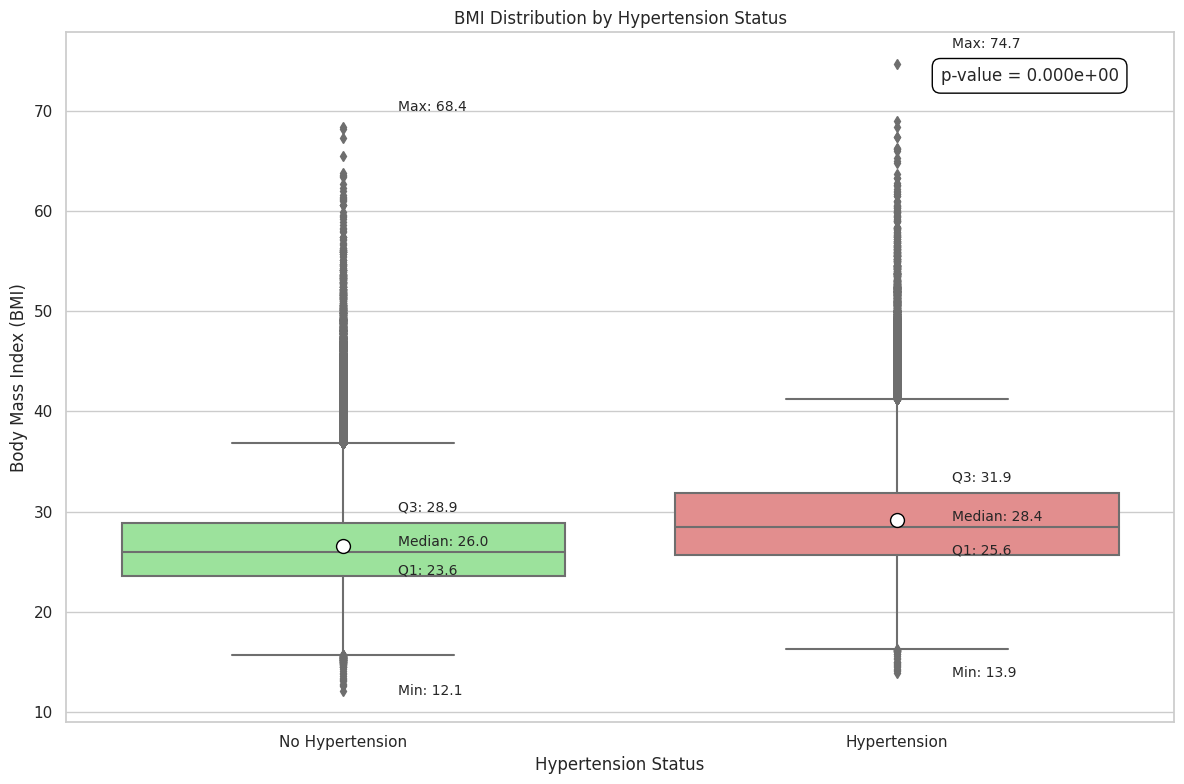

In [99]:
# BMI 

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Convert data types
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')  # Ensure BMI is numeric

# Drop rows with NaN values in BMI
df = df.dropna(subset=['BMI'])

# Perform t-test
no_htn_bmi = df[df['HTN_cc'] == 0]['BMI']
htn_bmi = df[df['HTN_cc'] == 1]['BMI']
t_stat, p_value = stats.ttest_ind(no_htn_bmi, htn_bmi)

# Plot settings
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Improve aesthetics

# Define a pastel color palette for the boxplot
palette = {0: 'lightgreen', 1: 'lightcoral'}  # No Hypertension: green, Hypertension: red

# Create the boxplot with custom colors and mean properties
ax = sns.boxplot(
    x='HTN_cc', 
    y='BMI', 
    data=df, 
    showmeans=True, 
    palette=palette,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10}  # Custom mean marker
)

plt.title('BMI Distribution by Hypertension Status')
plt.xlabel('Hypertension Status')
plt.ylabel('Body Mass Index (BMI)')
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'])

# Calculate statistics for each group and add text annotations
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['BMI']
    stats = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats['min'] + offsets[0], f"Min: {stats['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'] + offsets[1], f"Q1: {stats['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'] + offsets[2], f"Median: {stats['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'] + offsets[3], f"Q3: {stats['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'] + offsets[4], f"Max: {stats['max']:.1f}", ha='left', va='center', fontsize=10)

# Add p-value in a box at the top right corner
plt.text(0.95, 0.95, f'p-value = {p_value:.3e}', transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()



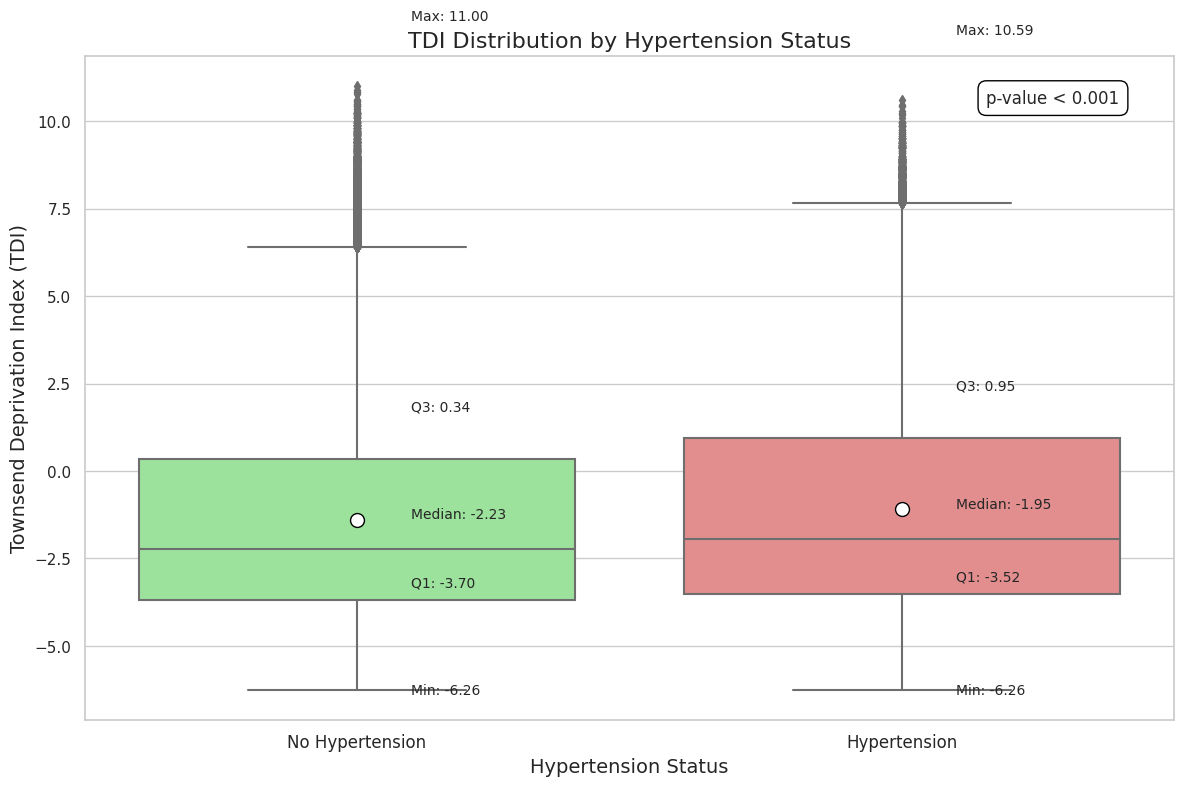

In [100]:
# TDI

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Convert data types if necessary
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['townsend_deprivation_index'] = pd.to_numeric(df['townsend_deprivation_index'], errors='coerce')

# Drop rows with NaN values in TDI
df = df.dropna(subset=['townsend_deprivation_index'])

# Perform t-test
no_htn_tdi = df[df['HTN_cc'] == 0]['townsend_deprivation_index']
htn_tdi = df[df['HTN_cc'] == 1]['townsend_deprivation_index']
t_stat, p_value = stats.ttest_ind(no_htn_tdi, htn_tdi)

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the box plot with specified colors for HTN and Non-HTN
ax = sns.boxplot(x='HTN_cc', y='townsend_deprivation_index', data=df, showmeans=True, 
                 palette={0: 'lightgreen', 1: 'lightcoral'},
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})

# Add titles and labels
plt.title('TDI Distribution by Hypertension Status', fontsize=16)
plt.xlabel('Hypertension Status', fontsize=14)
plt.ylabel('Townsend Deprivation Index (TDI)', fontsize=14)
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'], fontsize=12)

# Calculate statistics for each group and add text annotations
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['townsend_deprivation_index']
    stats = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats['min'] + offsets[0], f"Min: {stats['min']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'] + offsets[1], f"Q1: {stats['25%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'] + offsets[2], f"Median: {stats['50%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'] + offsets[3], f"Q3: {stats['75%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'] + offsets[4], f"Max: {stats['max']:.2f}", ha='left', va='center', fontsize=10)

# Add p-value in a box at the top right corner
p_value_text = f'p-value < 0.001' if p_value < 0.001 else f'p-value = {p_value:.3f}'
plt.text(0.95, 0.95, p_value_text, transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
         fontsize=12)

plt.tight_layout()
plt.show()



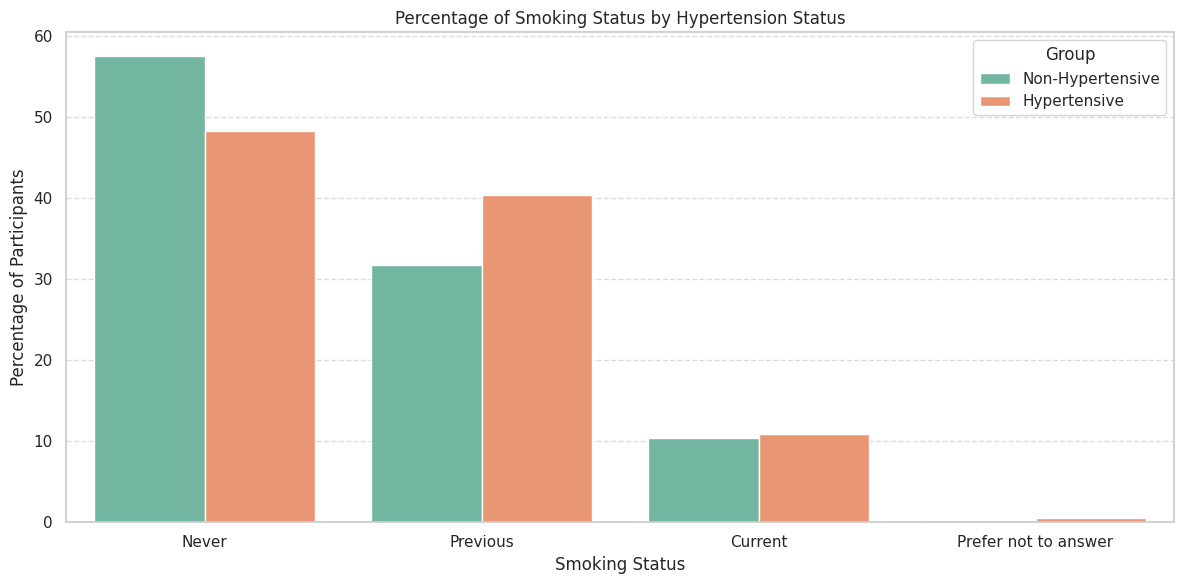

In [102]:
# smoking status 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data preparation (assuming df is your DataFrame)
# Filter for non-hypertensive patients
non_htn_df = df[df['HTN_cc'] == 0]
htn_df = df[df['HTN_cc'] == 1]

# Count occurrences of each smoking status
smoking_counts_non_htn = non_htn_df['smoking_status'].value_counts()
smoking_counts_htn = htn_df['smoking_status'].value_counts()

# Create a combined DataFrame
smoking_combined = pd.DataFrame({
    'Non-Hypertensive': smoking_counts_non_htn,
    'Hypertensive': smoking_counts_htn
}).fillna(0)  # Fill NaN values with 0

# Calculate percentages
smoking_percentages_combined = (smoking_combined.div(smoking_combined.sum(axis=0), axis=1)) * 100

# Reset index to use smoking statuses as a column
smoking_percentages_combined = smoking_percentages_combined.reset_index()
smoking_percentages_combined.columns = ['Smoking Status', 'Non-Hypertensive', 'Hypertensive']

# Create a bar chart
plt.figure(figsize=(12, 6))  # Set figure size

# Melt the DataFrame for seaborn compatibility
smoking_melted = smoking_percentages_combined.melt(id_vars='Smoking Status', var_name='Group', value_name='Percentage')

# Plotting the grouped bar chart using seaborn
sns.barplot(x='Smoking Status', y='Percentage', hue='Group', data=smoking_melted, palette='Set2')

# Add titles and labels
plt.title('Percentage of Smoking Status by Hypertension Status')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Participants')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


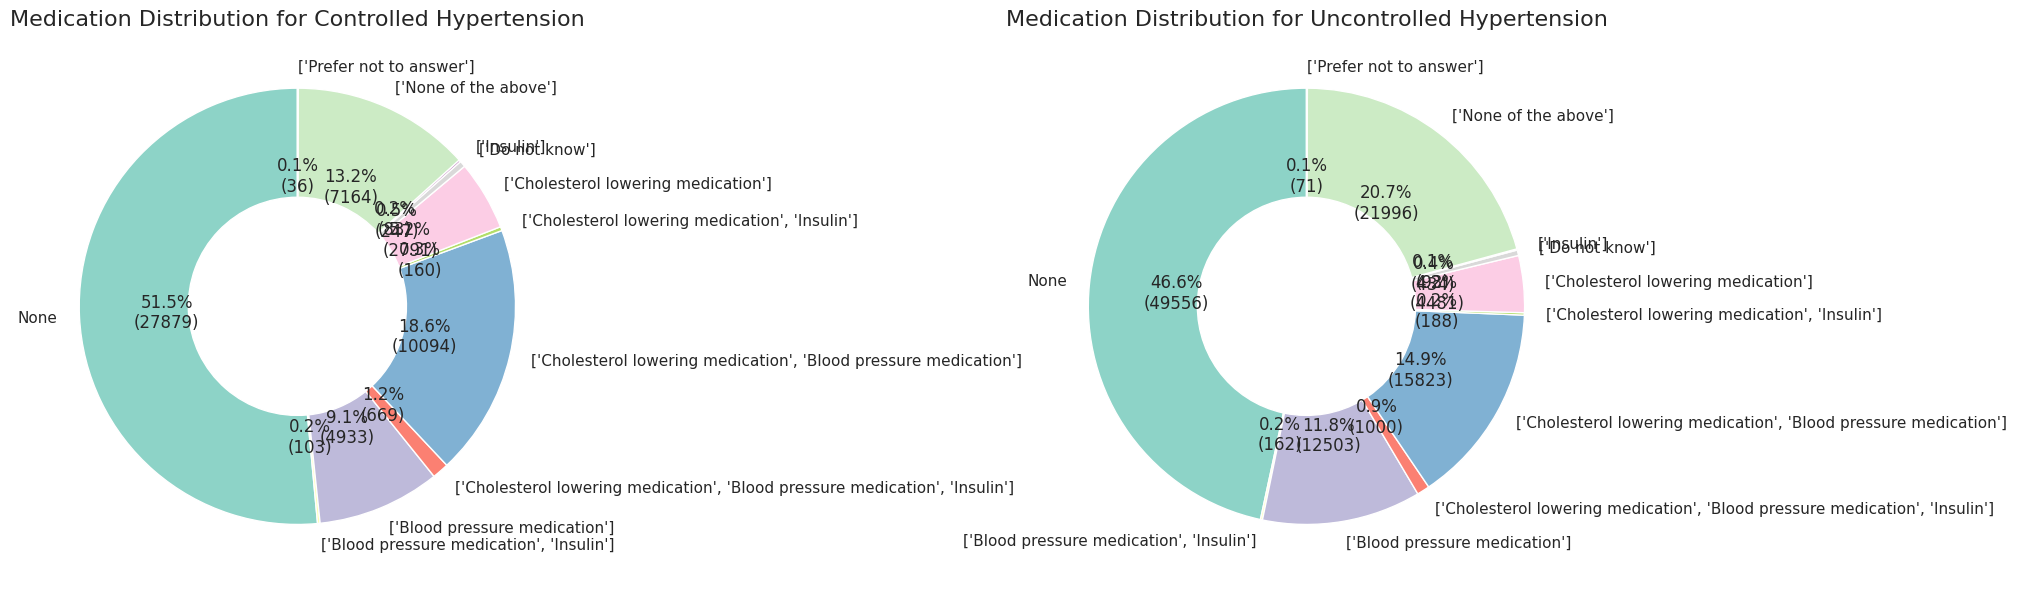

In [103]:
# medication by HTN control

import pandas as pd
import matplotlib.pyplot as plt

# Ensure the medication column is a categorical variable
df['Medication for cholesterol, blood pressure or diabetes'] = df['Medication for cholesterol, blood pressure or diabetes'].astype(str)

# Group by HTN control status and medication type to get counts
medication_counts = df.groupby(['HTN_Controlled', 'Medication for cholesterol, blood pressure or diabetes']).size().unstack(fill_value=0)

# Create pie charts for each group with increased size
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Increased figure size

# Color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(medication_counts.columns)))

# Function to create labels with percentages
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

# Pie chart for Controlled Hypertension
controlled_data = medication_counts.loc['Controlled']
axes[0].pie(controlled_data, labels=controlled_data.index, autopct=make_autopct(controlled_data), 
            startangle=90, colors=colors, wedgeprops=dict(width=0.5))
axes[0].set_title('Medication Distribution for Controlled Hypertension', fontsize=16)

# Pie chart for Uncontrolled Hypertension
uncontrolled_data = medication_counts.loc['Uncontrolled']
axes[1].pie(uncontrolled_data, labels=uncontrolled_data.index, autopct=make_autopct(uncontrolled_data), 
            startangle=90, colors=colors, wedgeprops=dict(width=0.5))
axes[1].set_title('Medication Distribution for Uncontrolled Hypertension', fontsize=16)

plt.tight_layout()
plt.show()


In [174]:
# try bar chart instead

Text(0, 0.5, 'Count')

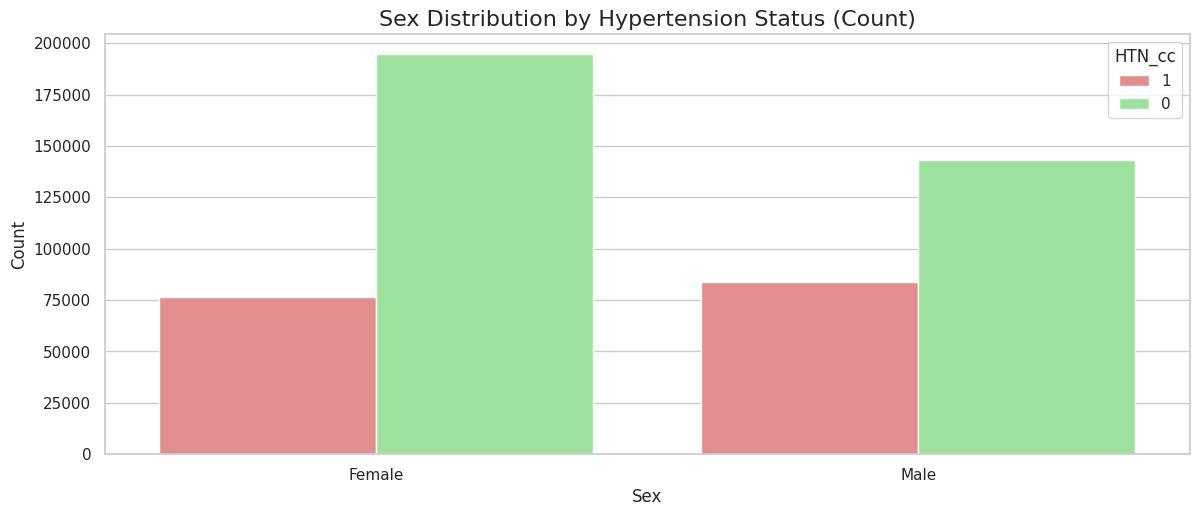

In [104]:
# sex by HTN (actual counts)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data to strings
df['HTN_cc'] = df['HTN_cc'].astype(str)

# colours
palette = {'0': 'lightgreen', '1': 'lightcoral'}

# Create figure
plt.figure(figsize=(14, 12))

# Count Plot
plt.subplot(2, 1, 1)
sns.countplot(x='sex', hue='HTN_cc', data=df, palette=palette)
plt.title('Sex Distribution by Hypertension Status (Count)', fontsize=16)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Count', fontsize=12)

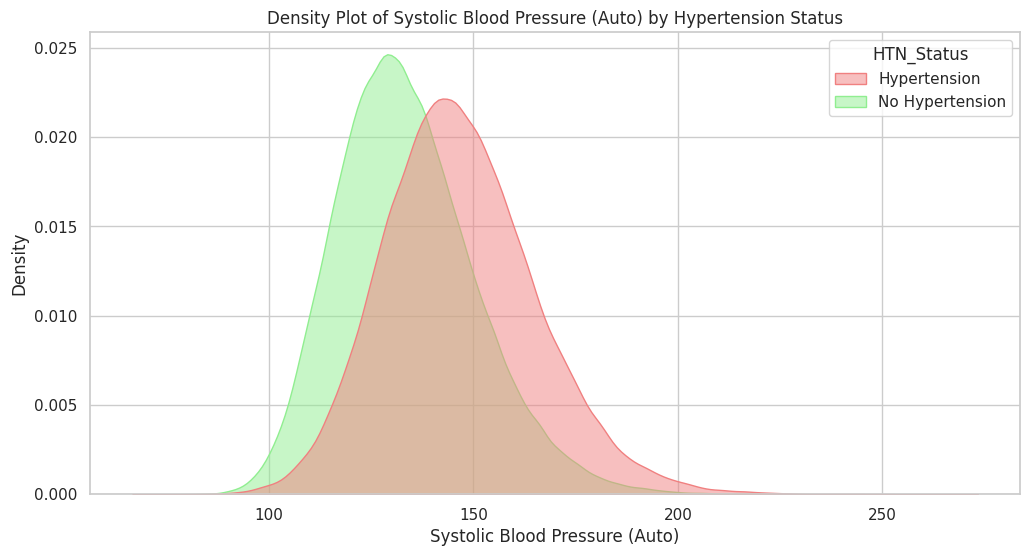

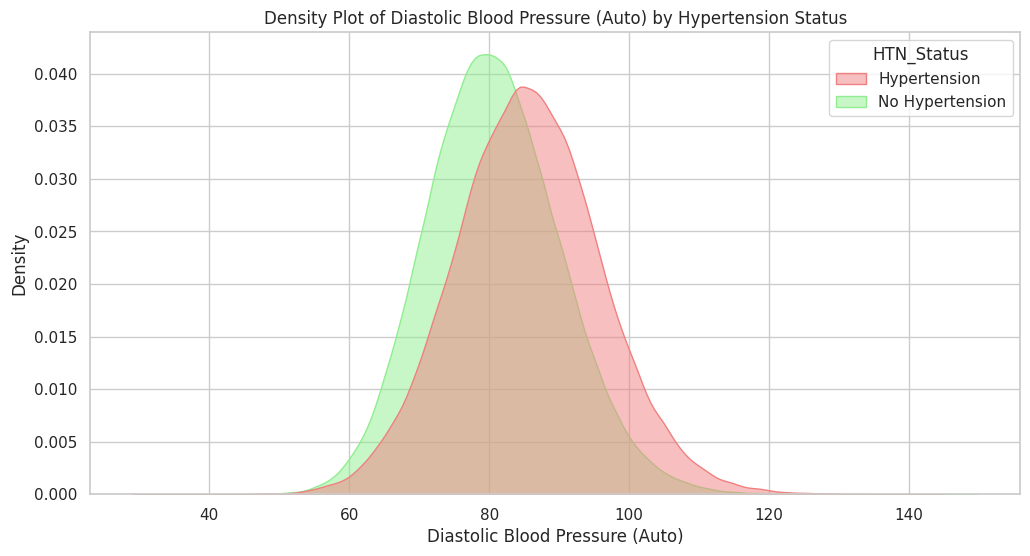

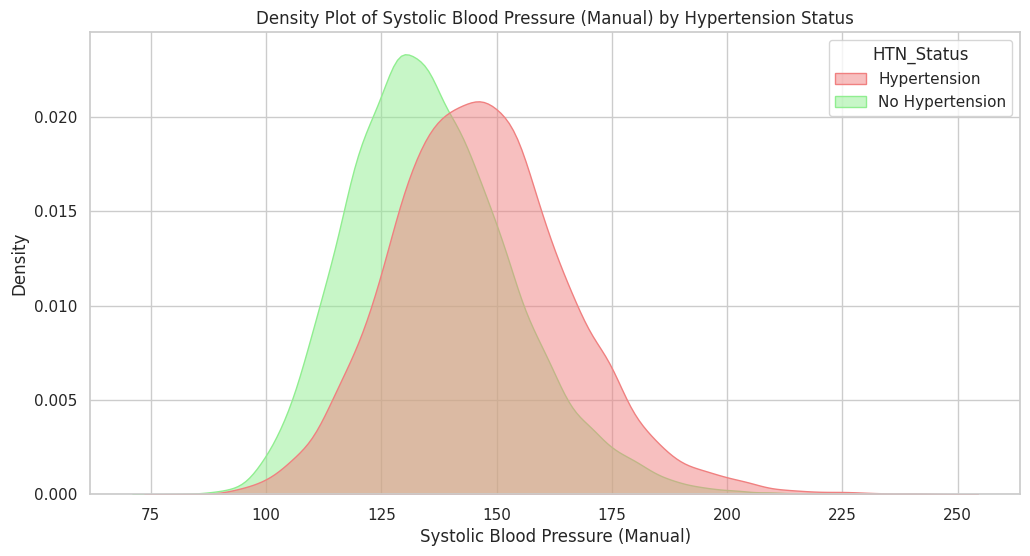

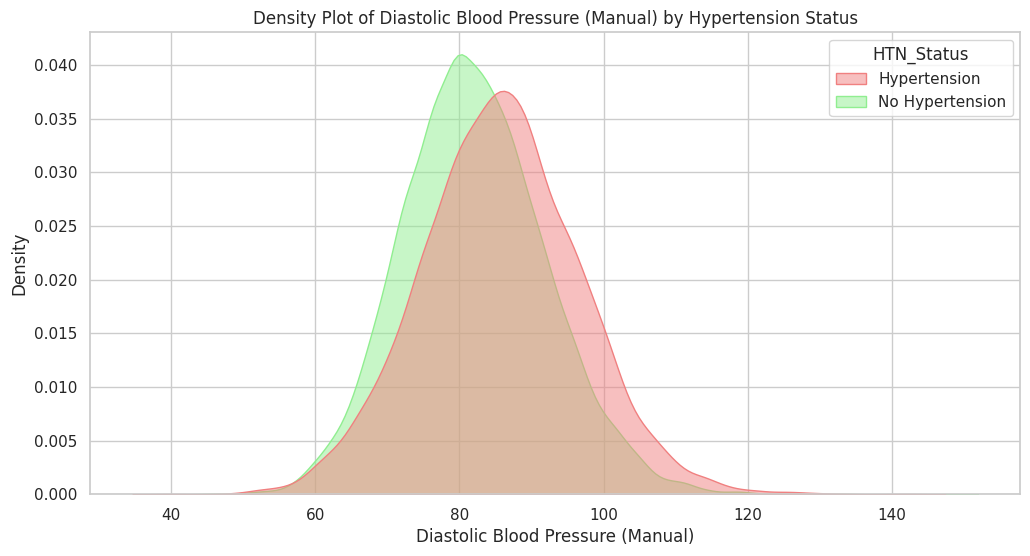

In [112]:
# density plots for SBP and DBP for HTN groups

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure columns are numeric and map hypertension status
df['SBP_auto_avg'] = pd.to_numeric(df['SBP_auto_avg'], errors='coerce')
df['DBP_auto_avg'] = pd.to_numeric(df['DBP_auto_avg'], errors='coerce')
df['SBP_man_avg'] = pd.to_numeric(df['SBP_man_avg'], errors='coerce')
df['DBP_man_avg'] = pd.to_numeric(df['DBP_man_avg'], errors='coerce')

df['HTN_Status'] = df['HTN_cc'].map({0: 'No Hypertension', 1: 'Hypertension'})

# Define variables and titles
variables = [
    ('SBP_auto_avg', 'Systolic Blood Pressure (Auto)'),
    ('DBP_auto_avg', 'Diastolic Blood Pressure (Auto)'),
    ('SBP_man_avg', 'Systolic Blood Pressure (Manual)'),
    ('DBP_man_avg', 'Diastolic Blood Pressure (Manual)')
]

# Define custom colors
custom_palette = {'Hypertension': 'lightcoral', 'No Hypertension': 'lightgreen'}

# Create plots
for var, title in variables:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=df, x=var, hue='HTN_Status', fill=True, common_norm=False, alpha=0.5, palette=custom_palette)
    plt.title(f'Density Plot of {title} by Hypertension Status')
    plt.xlabel(title)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


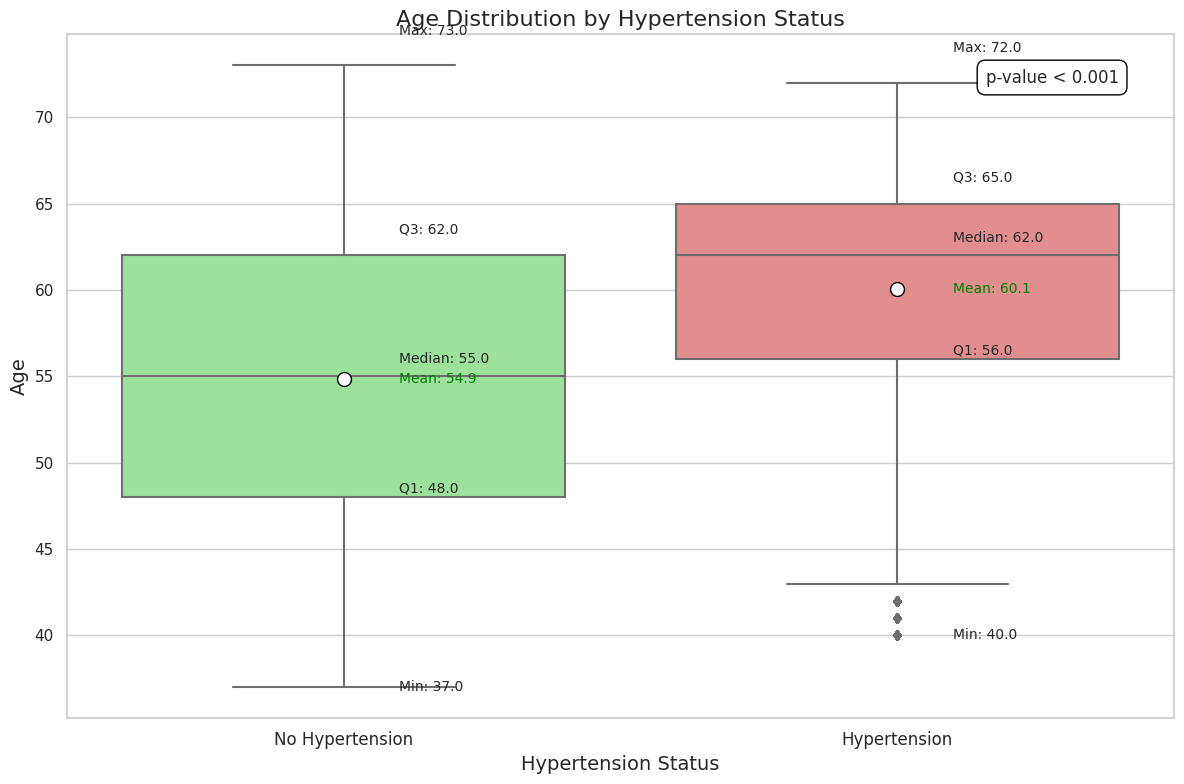

In [105]:
# age by HTN boxplot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Convert data types if necessary
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['age'] = df['age'].astype(float)

# Perform t-test
no_htn_age = df[df['HTN_cc'] == 0]['age']
htn_age = df[df['HTN_cc'] == 1]['age']
t_stat, p_value = stats.ttest_ind(no_htn_age, htn_age)

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the box plot with specified colors for HTN and Non-HTN
ax = sns.boxplot(x='HTN_cc', y='age', data=df, showmeans=True, 
                 palette={0: 'lightgreen', 1: 'lightcoral'},
                 meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10})

# Add titles and labels
plt.title('Age Distribution by Hypertension Status', fontsize=16)
plt.xlabel('Hypertension Status', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'], fontsize=12)

# Calculate statistics for each group and add text annotations
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['age']
    stats_group = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats_group['min'] + offsets[0], f"Min: {stats_group['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['25%'] + offsets[1], f"Q1: {stats_group['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['50%'] + offsets[2], f"Median: {stats_group['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['75%'] + offsets[3], f"Q3: {stats_group['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['max'] + offsets[4], f"Max: {stats_group['max']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['mean'], f"Mean: {stats_group['mean']:.1f}", ha='left', va='center', fontsize=10, color='green')

# Add p-value in a box at the top right corner
p_value_text = f'p-value < 0.001' if p_value < 0.001 else f'p-value = {p_value:.3f}'
plt.text(0.95, 0.95, p_value_text, transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
         fontsize=12)

plt.tight_layout()
plt.show()

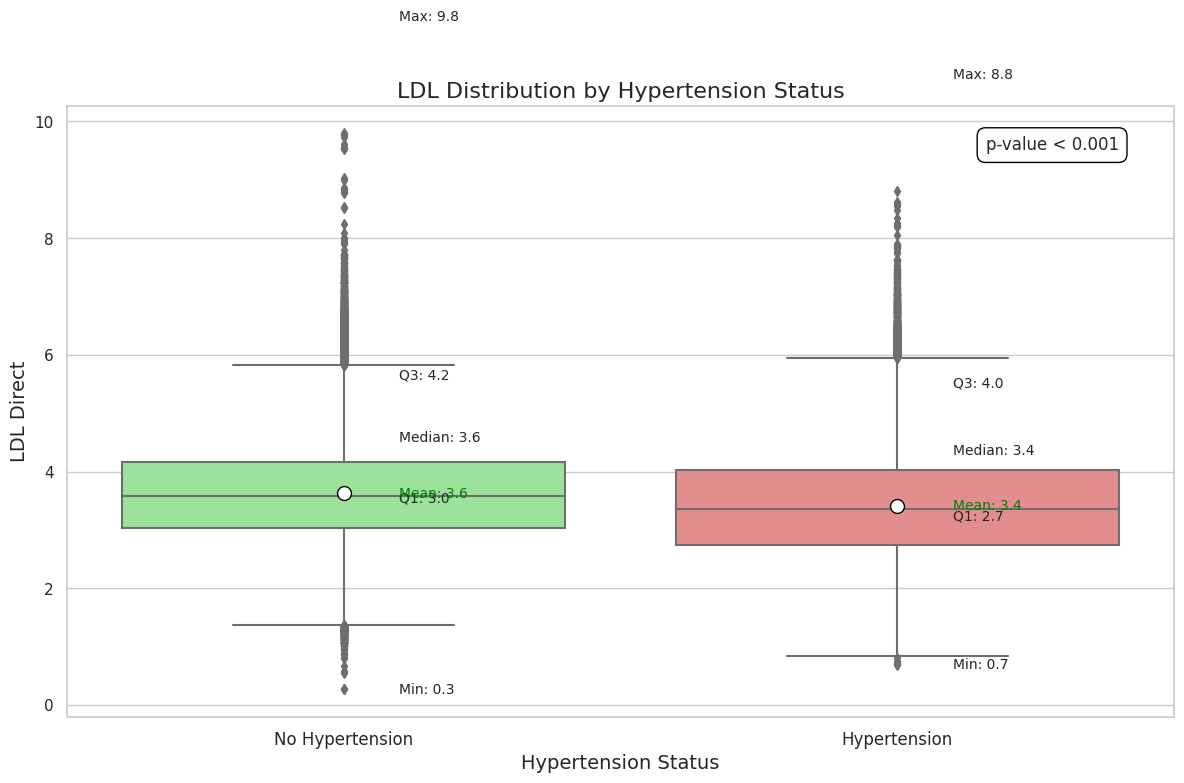

In [106]:
# LDL (good cholesterol)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Convert data types if necessary
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['LDL direct'] = pd.to_numeric(df['LDL direct'], errors='coerce')  # Ensure LDL is numeric

# Drop rows with NaN values in LDL (if any)
df = df.dropna(subset=['LDL direct'])

# Perform t-test for LDL direct by HTN status
no_htn_LDL = df[df['HTN_cc'] == 0]['LDL direct']
htn_LDL = df[df['HTN_cc'] == 1]['LDL direct']
t_stat, p_value = stats.ttest_ind(no_htn_LDL, htn_LDL)

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the box plot with specified colors for HTN and Non-HTN
ax = sns.boxplot(x='HTN_cc', y='LDL direct', data=df, showmeans=True, 
                 palette={0: 'lightgreen', 1: 'lightcoral'},
                 meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10})

# Add titles and labels
plt.title('LDL Distribution by Hypertension Status', fontsize=16)
plt.xlabel('Hypertension Status', fontsize=14)
plt.ylabel('LDL Direct', fontsize=14)
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'], fontsize=12)

# Calculate statistics for each group and add text annotations
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['LDL direct']
    stats_group = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats_group['min'] + offsets[0], f"Min: {stats_group['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['25%'] + offsets[1], f"Q1: {stats_group['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['50%'] + offsets[2], f"Median: {stats_group['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['75%'] + offsets[3], f"Q3: {stats_group['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['max'] + offsets[4], f"Max: {stats_group['max']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['mean'], f"Mean: {stats_group['mean']:.1f}", ha='left', va='center', fontsize=10, color='green')

# Add p-value in a box at the top right corner
p_value_text = f'p-value < 0.001' if p_value < 0.001 else f'p-value = {p_value:.3f}'
plt.text(0.95, 0.95, p_value_text, transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
         fontsize=12)

plt.tight_layout()
plt.show()


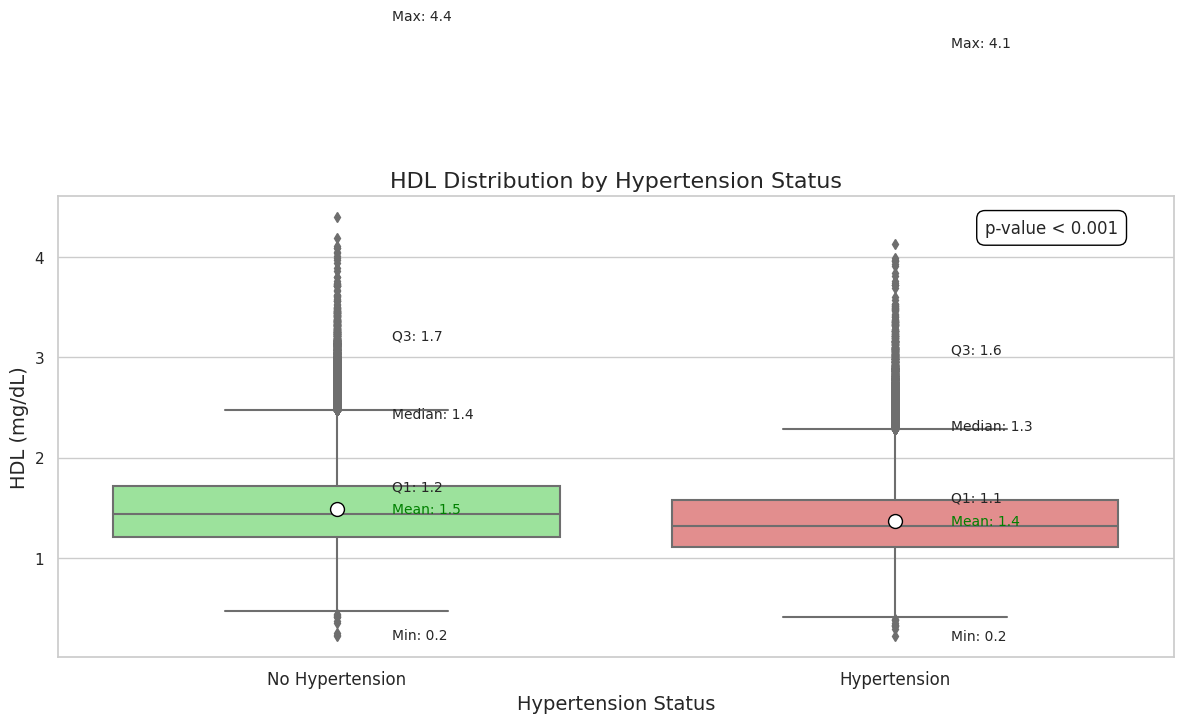

In [107]:
# HDL (bad)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Convert data types if necessary
df['HTN_cc'] = df['HTN_cc'].astype(int)
df['HDL cholesterol'] = pd.to_numeric(df['HDL cholesterol'], errors='coerce')

# Drop rows with NaN values in HDL
df = df.dropna(subset=['HDL cholesterol'])

# Perform t-test
no_htn_HDL = df[df['HTN_cc'] == 0]['HDL cholesterol']
htn_HDL = df[df['HTN_cc'] == 1]['HDL cholesterol']
t_stat, p_value = stats.ttest_ind(no_htn_HDL, htn_HDL)

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the box plot with specified colors for HTN and Non-HTN
ax = sns.boxplot(x='HTN_cc', y='HDL cholesterol', data=df, showmeans=True, 
                 palette={0: 'lightgreen', 1: 'lightcoral'},
                 meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10})

# Add titles and labels
plt.title('HDL Distribution by Hypertension Status', fontsize=16)
plt.xlabel('Hypertension Status', fontsize=14)
plt.ylabel('HDL (mg/dL)', fontsize=14)
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'], fontsize=12)

# Calculate statistics for each group and add text annotations
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['HTN_cc'] == htn_group]['HDL cholesterol']
    stats_group = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats_group['min'] + offsets[0], f"Min: {stats_group['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['25%'] + offsets[1], f"Q1: {stats_group['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['50%'] + offsets[2], f"Median: {stats_group['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['75%'] + offsets[3], f"Q3: {stats_group['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['max'] + offsets[4], f"Max: {stats_group['max']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats_group['mean'], f"Mean: {stats_group['mean']:.1f}", ha='left', va='center', fontsize=10, color='green')

# Add p-value in a box at the top right corner
p_value_text = f'p-value < 0.001' if p_value < 0.001 else f'p-value = {p_value:.3f}'
plt.text(0.95, 0.95, p_value_text, transform=plt.gca().transAxes, 
         horizontalalignment='right', verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
         fontsize=12)

plt.tight_layout()
plt.show()


In [212]:
# BP by age group 


In [216]:
# bp density plots

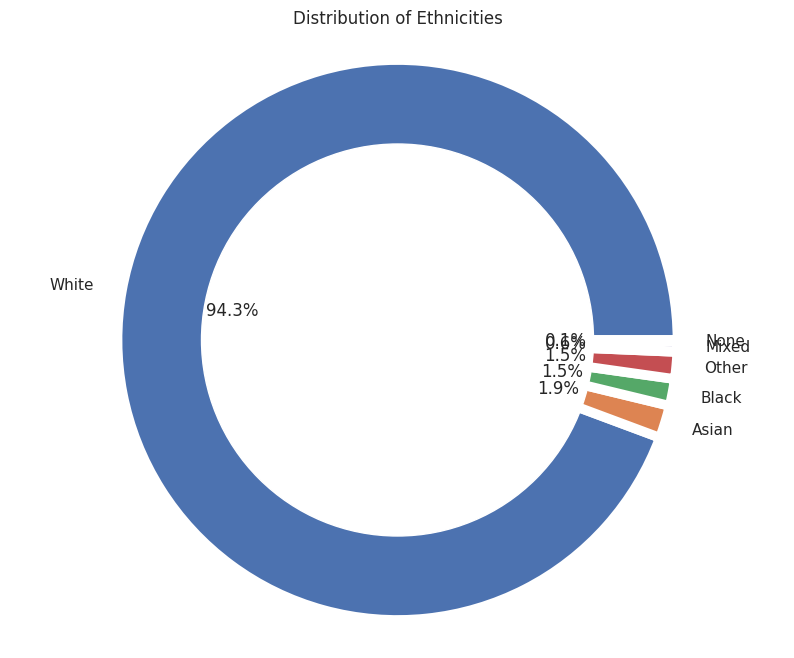

In [108]:
# ethnicity 
# library
import matplotlib.pyplot as plt

# Count the number of people in each ethnicity
ethnicity_counts = df['ethnic_background'].value_counts()

# Create a circle at the center of the plot
my_circle = plt.Circle((0, 0), 0.7, color='white')

# Create pie chart with custom wedges
plt.figure(figsize=(10, 8))
plt.pie(ethnicity_counts.values, labels=ethnicity_counts.index, 
        wedgeprops={'linewidth': 7, 'edgecolor': 'white'}, 
        autopct='%1.1f%%')

# Add the circle to the pie chart
p = plt.gcf()
p.gca().add_artist(my_circle)

# Set title and display the plot
plt.title('Distribution of Ethnicities')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




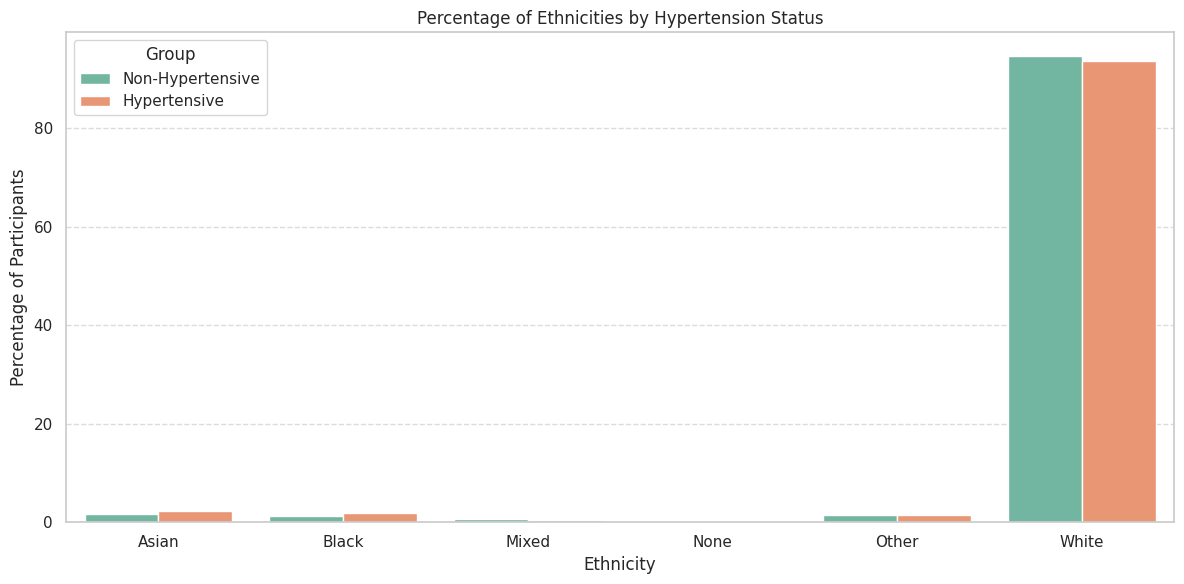

In [109]:
# ethnicities 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data preparation (assuming df is your DataFrame)
# Filter for non-hypertensive patients
non_htn_df = df[df['HTN_cc'] == 0]

# Filter for hypertensive patients
htn_df = df[df['HTN_cc'] == 1]

# Count occurrences of each ethnicity in both groups
ethnicity_counts_non_htn = non_htn_df['ethnic_background'].value_counts()
ethnicity_counts_htn = htn_df['ethnic_background'].value_counts()

# Create a combined DataFrame
ethnicity_combined = pd.DataFrame({
    'Non-Hypertensive': ethnicity_counts_non_htn,
    'Hypertensive': ethnicity_counts_htn
}).fillna(0)  # Fill NaN values with 0

# Calculate percentages
ethnicity_percentages_combined = (ethnicity_combined.div(ethnicity_combined.sum(axis=0), axis=1)) * 100

# Reset index to use ethnicities as a column
ethnicity_percentages_combined = ethnicity_percentages_combined.reset_index()
ethnicity_percentages_combined.columns = ['Ethnicity', 'Non-Hypertensive', 'Hypertensive']

# Create a bar chart
plt.figure(figsize=(12, 6))  # Set figure size

# Melt the DataFrame for seaborn compatibility
ethnicity_melted = ethnicity_percentages_combined.melt(id_vars='Ethnicity', var_name='Group', value_name='Percentage')

# Plotting the grouped bar chart using seaborn
sns.barplot(x='Ethnicity', y='Percentage', hue='Group', data=ethnicity_melted, palette='Set2')

# Add titles and labels
plt.title('Percentage of Ethnicities by Hypertension Status')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Participants')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
